# Leakage Prediction Using Recurrent Neural Networks (RNN)

## Task Overview
This project aims to develop a predictive model to classify leakage events in a system based on time-series sensor data. The primary objective is to implement a sliding window technique to preprocess the data and use Recurrent Neural Networks (RNN) to represent and predict leakage occurrences at the end of each window.

## Aim
The aim of this project is to accurately predict leakage events using historical sensor data by training an RNN model. The model will learn to generate embeddings for the sensor data within a specified window and utilize these embeddings for the classification task.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SimpleRNN
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers.legacy import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# Read the data from an Excel file
file_path = './Resources/job2.xlsx'  # replace with your file path
sensor_data = pd.read_excel(file_path, engine='openpyxl')

# Print Sensor data
sensor_data.head()

,year,month,day,hour,minute,WMS0117,WMS0103.A3,WMS0104.A3,WMS0116.A3,WBS628.A3,DMA_Formula,job_id,Latitude,Longitude,label
0,2023,4,0,16,50,89.853652,21.182875,15.539593,3.048911,12.6875,27.083878,NaN,NaN,NaN,0
1,2023,4,0,16,55,90.353450,19.371502,13.674322,3.892524,13.3125,23.625848,NaN,NaN,NaN,0
2,2023,4,0,17,0,90.383438,19.328417,13.359525,3.220116,13.6250,22.283058,NaN,NaN,NaN,0
3,2023,4,0,17,5,90.223502,19.597952,13.474276,3.220116,13.2500,23.042344,NaN,NaN,NaN,0
4,2023,4,0,17,10,90.333458,21.468199,14.117642,3.765531,13.6875,25.663872,NaN,NaN,NaN,0


In [3]:
df = sensor_data

In [4]:
# Function to create sliding windows
def create_sliding_window(df, window_size=20, step_size=1):
    X, y = [], []
    for start in range(0, len(df) - window_size + 1, step_size):
        end = start + window_size
        window = df.iloc[start:end]
        X.append(window.drop(columns=['label', 'job_id']).values)
        y.append(window['label'].values[-1])
    return np.array(X), np.array(y)

# Prepare data using sliding window
features, target = create_sliding_window(df, window_size=20)

In [5]:
# Train-test split for Validation and Testing
X_train, X_tmp, y_train, y_tmp = train_test_split(features, target, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

# Check data split sizes
print("Shape of Training Set: ", X_train.shape)
print("Shape of Validation Set: ", X_val.shape)
print("Shape of Testing Set: ", X_test.shape)

Shape of Training Set:  (80777, 20, 13)
Shape of Validation Set:  (10097, 20, 13)
Shape of Testing Set:  (10098, 20, 13)


In [6]:
# Initialize a sequential model
model = Sequential()

# RNN layers
model.add(SimpleRNN(70, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(SimpleRNN(48, activation='relu'))

# Dense layer and Dropout Layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))

# Dense layer and Dropout Layer
model.add(Dense(36, activation='relu'))
model.add(Dropout(0.1))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Print model summary
model.summary()

/Users/sushilr/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 20, 70)         │         5,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 48)             │         5,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         2,340 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            37 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,105 (66.82 KB)

 Trainable params: 17,105 (66.82 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Adding early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-9, restore_best_weights=True)

In [8]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=120, 
                    validation_data=(X_val, y_val))

Epoch 1/120
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9802 - loss: nan - val_accuracy: 0.9790 - val_loss: nan
Epoch 2/120
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9808 - loss: nan - val_accuracy: 0.9790 - val_loss: nan
Epoch 3/120
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9805 - loss: nan - val_accuracy: 0.9790 - val_loss: nan
Epoch 4/120
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9805 - loss: nan - val_accuracy: 0.9790 - val_loss: nan
Epoch 5/120
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9806 - loss: nan - val_accuracy: 0.9790 - val_loss: nan
Epoch 6/120
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9798 - loss: nan - val_accuracy: 0.9790 - val_loss: nan
Epoch 7/120
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9799 - loss: nan - val_accuracy: 0.9790 - val_loss: nan
Epoch 8/120
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9802 - loss: nan - val_accuracy: 0.9790 - val_loss: nan


2525/2525 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9794 - loss: nan - val_accuracy: 0.9790 - val_loss: nan
Epoch 53/120
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9797 - loss: nan - val_accuracy: 0.9790 - val_loss: nan
Epoch 54/120
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9807 - loss: nan - val_accuracy: 0.9790 - val_loss: nan
Epoch 55/120
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9809 - loss: nan - val_accuracy: 0.9790 - val_loss: nan
Epoch 56/120
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9806 - loss: nan - val_accuracy: 0.9790 - val_loss: nan
Epoch 57/120
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9803 - loss: nan - val_accuracy: 0.9790 - val_loss: nan
Epoch 58/120
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9806 - loss: nan - val_accuracy: 0.9790 - val_loss: nan
Epoch 59/120
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9797 - loss: nan - val_accuracy: 0.9790 - val_loss: nan
Epoch

2525/2525 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9799 - loss: nan - val_accuracy: 0.9790 - val_loss: nan
Epoch 104/120
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9806 - loss: nan - val_accuracy: 0.9790 - val_loss: nan
Epoch 105/120
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9807 - loss: nan - val_accuracy: 0.9790 - val_loss: nan
Epoch 106/120
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9807 - loss: nan - val_accuracy: 0.9790 - val_loss: nan
Epoch 107/120
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9800 - loss: nan - val_accuracy: 0.9790 - val_loss: nan
Epoch 108/120
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9805 - loss: nan - val_accuracy: 0.9790 - val_loss: nan
Epoch 109/120
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9800 - loss: nan - val_accuracy: 0.9790 - val_loss: nan
Epoch 110/120
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9806 - loss: nan - val_accuracy: 0.9790 - val_loss: na

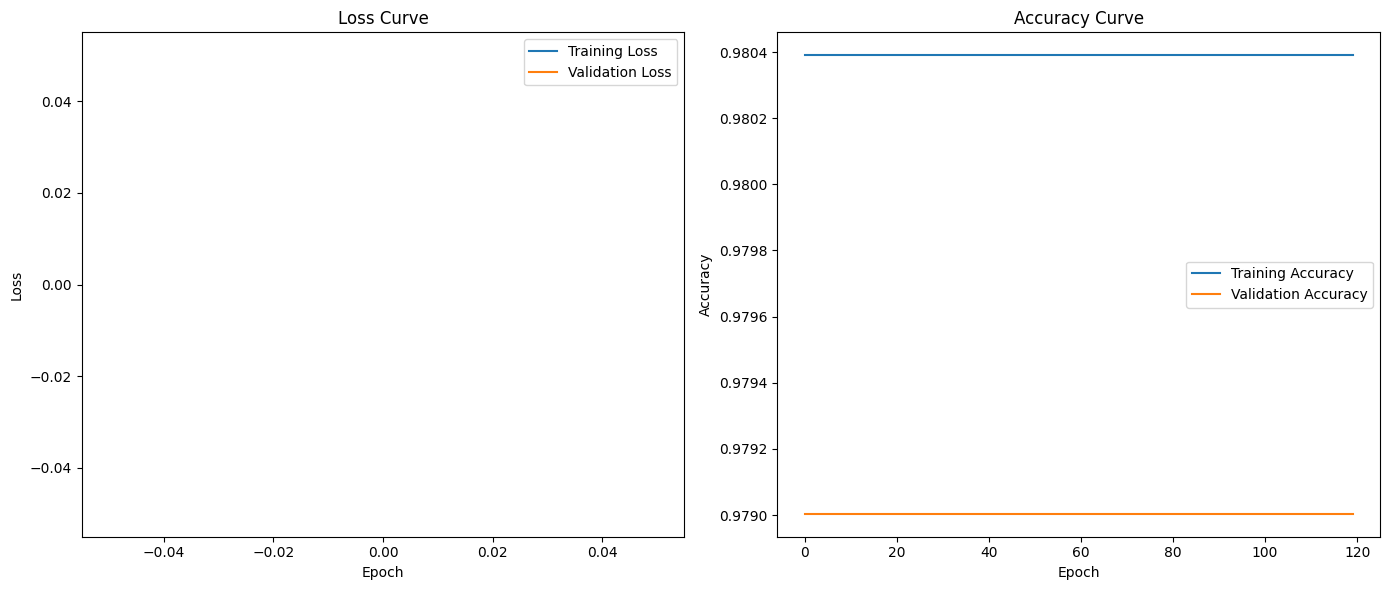

In [9]:
# Extract loss and accuracy values from history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot loss
ax1.plot(loss, label='Training Loss')
ax1.plot(val_loss, label='Validation Loss')
ax1.set_title('Loss Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot accuracy
ax2.plot(accuracy, label='Training Accuracy')
ax2.plot(val_accuracy, label='Validation Accuracy')
ax2.set_title('Accuracy Curve')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Display plots
plt.tight_layout()
plt.show()

In [10]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.9739 - loss: nan
Test Loss: nan
Test Accuracy: 0.9776193499565125


# Job 2

In [11]:
# Filter the dataset where label == 1
leakage_data = sensor_data[sensor_data['label'] == 1]

In [12]:
leakage_data.head()

,year,month,day,hour,minute,WMS0117,WMS0103.A3,WMS0104.A3,WMS0116.A3,WBS628.A3,DMA_Formula,job_id,Latitude,Longitude,label
840,2023,4,0,14,50,91.712900,18.639154,12.325843,4.026223,12.2500,22.741220,8088170.0,-37.76597,145.124678,1
841,2023,4,0,14,55,91.143130,18.638672,12.135448,3.855910,12.3125,22.317529,8088170.0,-37.76597,145.124678,1
842,2023,4,0,15,0,91.293070,17.906879,12.752417,4.207902,12.1875,22.679698,8088170.0,-37.76597,145.124678,1
843,2023,4,0,15,5,91.443009,18.212448,12.525876,4.207902,12.8750,22.071226,8088170.0,-37.76597,145.124678,1
844,2023,4,0,15,10,91.712900,20.468033,12.276958,3.878753,12.7500,23.873744,8088170.0,-37.76597,145.124678,1


In [13]:
leakage_data.count

<bound method DataFrame.count of        year  month  day  hour  minute    WMS0117  WMS0103.A3  WMS0104.A3  \
840    2023      4    0    14      50  91.712900   18.639154   12.325843   
841    2023      4    0    14      55  91.143130   18.638672   12.135448   
842    2023      4    0    15       0  91.293070   17.906879   12.752417   
843    2023      4    0    15       5  91.443009   18.212448   12.525876   
844    2023      4    0    15      10  91.712900   20.468033   12.276958   
...     ...    ...  ...   ...     ...        ...         ...         ...   
94398  2024      3    0    11      20  91.093150   37.066971   15.742248   
94399  2024      3    0    11      25  90.963203   36.924599   15.730635   
94400  2024      3    0    11      30  92.032770   34.880939   12.450662   
94401  2024      3    0    11      35  91.502985   36.717873   14.629647   
94402  2024      3    0    11      40  91.083155   34.042675   14.629647   

       WMS0116.A3  WBS628.A3  DMA_Formula     job_id  

In [14]:
# Sensor coordinates
sensor_coords = {
    'WMS0117_1': (37.758, 145.135),
    'WMS0103': (37.768, 145.131),
    'WMS0104': (37.767, 145.119),
    'WMS0116': (37.767, 145.141),
    'WBS628': (37.758, 145.118)
}

In [15]:
# calculating Euclidean distance
def calculate_distance(lat1, lon1, lat2, lon2):
    return np.sqrt((lat1 - lat2) ** 2 + (lon1 - lon2) ** 2)


In [16]:
# Calculate distances for each leakage location
distances = []
for index, row in leakage_data.iterrows():
    lat, lon = row['Latitude'], row['Longitude']
    row_distances = {
        sensor: calculate_distance(lat, lon, coords[0], coords[1])
        for sensor, coords in sensor_coords.items()
    }
    distances.append(row_distances)

In [17]:
# Convert distances to DataFrame
distances_df = pd.DataFrame(distances)

# Display the calculated distances
print(distances_df)

      WMS0117_1    WMS0103    WMS0104    WMS0116     WBS628
0     75.523971  75.533970  75.532970  75.532972  75.523970
1     75.523971  75.533970  75.532970  75.532972  75.523970
2     75.523971  75.533970  75.532970  75.532972  75.523970
3     75.523971  75.533970  75.532970  75.532972  75.523970
4     75.523971  75.533970  75.532970  75.532972  75.523970
...         ...        ...        ...        ...        ...
2017  75.522964  75.532964  75.531964  75.531965  75.522964
2018  75.522964  75.532964  75.531964  75.531965  75.522964
2019  75.522964  75.532964  75.531964  75.531965  75.522964
2020  75.522964  75.532964  75.531964  75.531965  75.522964
2021  75.522964  75.532964  75.531964  75.531965  75.522964

[2022 rows x 5 columns]


In [19]:
# Merge sensor data with distances
sensor_data_with_distances = sensor_data[sensor_data['label'] == 1].reset_index(drop=True)
sensor_data_with_distances = pd.concat([sensor_data_with_distances, distances_df], axis=1)

In [20]:
sensor_data_with_distances[['WMS0117_1', 'WMS0103', 'WMS0104', 'WMS0116', 'WBS628']].values[-1]

array([75.5229643 , 75.53296386, 75.53196384, 75.53196534, 75.52296393])

In [21]:
# Function to create sliding windows
def create_sliding_window(df, window_size=20, step_size=1):
    X, y = [], []
    for start in range(0, len(df) - window_size + 1, step_size):
        end = start + window_size
        window = df.iloc[start:end]
        X.append(window.drop(columns=['label', 'job_id', 'Latitude', 'Longitude']).values)
        y.append(window[['WMS0117', 'WMS0103', 'WMS0104', 'WMS0116', 'WBS628']].values[-1])
    return np.array(X), np.array(y)

# Prepare data using sliding window
window_size = 20
features, target = create_sliding_window(sensor_data_with_distances, window_size)

In [22]:
# Train-test split for validation and testing
X_train, X_tmp, y_train, y_tmp = train_test_split(features, target, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

In [23]:
target.shape

(2003, 5)

In [24]:
# Check data split sizes
print("Shape of Training Set: ", X_train.shape)
print("Shape of Validation Set: ", X_val.shape)
print("Shape of Testing Set: ", X_test.shape)

Shape of Training Set:  (1602, 20, 16)
Shape of Validation Set:  (200, 20, 16)
Shape of Testing Set:  (201, 20, 16)


In [25]:
# Initialize a sequential model
model = Sequential()

# RNN layers
model.add(SimpleRNN(70, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(SimpleRNN(48, activation='relu'))

# Dense layer and Dropout Layer
model.add(Dense(36, activation='relu'))
model.add(Dropout(0.1))

# Output layers for distance predictions
model.add(Dense(5))  # 5 sensors

# Print model summary
model.summary()

/Users/sushilr/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 20, 70)         │         6,090 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 48)             │         5,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 36)             │         1,764 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 36)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           185 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,751 (53.71 KB)

 Trainable params: 13,751 (53.71 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Adding early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-9, restore_best_weights=True)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='mse', metrics=['mae'])

In [27]:
# Train the model
history = model.fit(X_train, y_train, 
                    epochs=250, 
                    validation_data=(X_val, y_val), 
                    callbacks=[reduce_lr])

Epoch 1/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 78000.4688 - mae: 261.0815 - val_loss: 61480.3711 - val_mae: 235.6249 - learning_rate: 1.0000e-05
Epoch 2/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 60577.8008 - mae: 227.2746 - val_loss: 48947.3438 - val_mae: 207.4295 - learning_rate: 1.0000e-05
Epoch 3/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 49196.0156 - mae: 201.4905 - val_loss: 39210.7734 - val_mae: 183.3398 - learning_rate: 1.0000e-05
Epoch 4/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 39482.5977 - mae: 177.8898 - val_loss: 31785.3652 - val_mae: 162.0595 - learning_rate: 1.0000e-05
Epoch 5/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30780.6094 - mae: 153.0886 - val_loss: 19695.9492 - val_mae: 118.7057 - learning_rate: 1.0000e-05
Epoch 6/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19790.3301 - mae: 117.3673 - val_loss: 13587.7373 - val_mae: 97.6521 - learning_rate: 1.0000e-05
Epoch 7/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 

Epoch 45/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 671.7061 - mae: 18.2688 - val_loss: 37.8157 - val_mae: 5.5145 - learning_rate: 1.0000e-05
Epoch 46/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 654.6703 - mae: 17.8909 - val_loss: 37.5354 - val_mae: 5.4961 - learning_rate: 1.0000e-05
Epoch 47/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 628.2961 - mae: 17.6538 - val_loss: 36.3044 - val_mae: 5.4118 - learning_rate: 1.0000e-05
Epoch 48/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 626.4998 - mae: 17.4563 - val_loss: 36.1447 - val_mae: 5.3928 - learning_rate: 1.0000e-05
Epoch 49/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 619.7744 - mae: 17.4621 - val_loss: 34.0671 - val_mae: 5.2489 - learning_rate: 1.0000e-05
Epoch 50/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 611.0417 - mae: 17.3713 - val_loss: 33.1295 - val_mae: 5.1552 - learning_rate: 1.0000e-05
Epoch 51/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 632.3124 - mae: 17.8606 - val_loss: 31.2

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 281.6111 - mae: 11.4900 - val_loss: 15.1944 - val_mae: 3.3176 - learning_rate: 1.0000e-05
Epoch 90/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 274.0821 - mae: 11.4264 - val_loss: 14.8586 - val_mae: 3.2616 - learning_rate: 1.0000e-05
Epoch 91/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 275.2014 - mae: 11.2786 - val_loss: 14.7835 - val_mae: 3.2539 - learning_rate: 1.0000e-05
Epoch 92/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 263.8166 - mae: 11.2584 - val_loss: 15.0529 - val_mae: 3.2947 - learning_rate: 1.0000e-05
Epoch 93/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 286.7134 - mae: 11.5787 - val_loss: 15.3267 - val_mae: 3.3556 - learning_rate: 1.0000e-05
Epoch 94/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 266.4229 - mae: 11.2509 - val_loss: 14.9747 - val_mae: 3.3164 - learning_rate: 1.0000e-05
Epoch 95/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 276.2991 - mae: 11.3853 - val_loss: 16.5976 - val_mae

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 256.2933 - mae: 11.1795 - val_loss: 13.2849 - val_mae: 3.0572 - learning_rate: 3.1250e-07
Epoch 134/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 240.3021 - mae: 10.7689 - val_loss: 13.3438 - val_mae: 3.0644 - learning_rate: 3.1250e-07
Epoch 135/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 243.2200 - mae: 10.9729 - val_loss: 13.3331 - val_mae: 3.0671 - learning_rate: 3.1250e-07
Epoch 136/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 249.7533 - mae: 11.1148 - val_loss: 13.3482 - val_mae: 3.0676 - learning_rate: 1.5625e-07
Epoch 137/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 249.4849 - mae: 11.0130 - val_loss: 13.3420 - val_mae: 3.0675 - learning_rate: 1.5625e-07
Epoch 138/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 270.7292 - mae: 11.5074 - val_loss: 13.3088 - val_mae: 3.0633 - learning_rate: 1.5625e-07
Epoch 139/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 253.3251 - mae: 11.1204 - val_loss: 13.3114 - v

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 247.1212 - mae: 11.1191 - val_loss: 13.2531 - val_mae: 3.0609 - learning_rate: 1.0000e-09
Epoch 178/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 255.9690 - mae: 11.2319 - val_loss: 13.2531 - val_mae: 3.0609 - learning_rate: 1.0000e-09
Epoch 179/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 255.9146 - mae: 11.1093 - val_loss: 13.2531 - val_mae: 3.0609 - learning_rate: 1.0000e-09
Epoch 180/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 238.9901 - mae: 10.7793 - val_loss: 13.2531 - val_mae: 3.0609 - learning_rate: 1.0000e-09
Epoch 181/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 242.0867 - mae: 10.8937 - val_loss: 13.2531 - val_mae: 3.0609 - learning_rate: 1.0000e-09
Epoch 182/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 249.9437 - mae: 11.1161 - val_loss: 13.2530 - val_mae: 3.0609 - learning_rate: 1.0000e-09
Epoch 183/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 251.1004 - mae: 11.1409 - val_loss: 13.2530 - v

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 270.3868 - mae: 11.3863 - val_loss: 13.2520 - val_mae: 3.0607 - learning_rate: 1.0000e-09
Epoch 222/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 264.7172 - mae: 11.4318 - val_loss: 13.2520 - val_mae: 3.0607 - learning_rate: 1.0000e-09
Epoch 223/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 269.9226 - mae: 11.6097 - val_loss: 13.2520 - val_mae: 3.0607 - learning_rate: 1.0000e-09
Epoch 224/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 228.9300 - mae: 10.6892 - val_loss: 13.2519 - val_mae: 3.0607 - learning_rate: 1.0000e-09
Epoch 225/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 244.2304 - mae: 11.0475 - val_loss: 13.2519 - val_mae: 3.0607 - learning_rate: 1.0000e-09
Epoch 226/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 230.8393 - mae: 10.7522 - val_loss: 13.2519 - val_mae: 3.0607 - learning_rate: 1.0000e-09
Epoch 227/250
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 251.5182 - mae: 10.9924 - val_loss: 13.2518 - v

In [28]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test MAE: {mae}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13.0771 - mae: 3.0412 
Test Loss: 13.06391716003418
Test MAE: 3.018799066543579


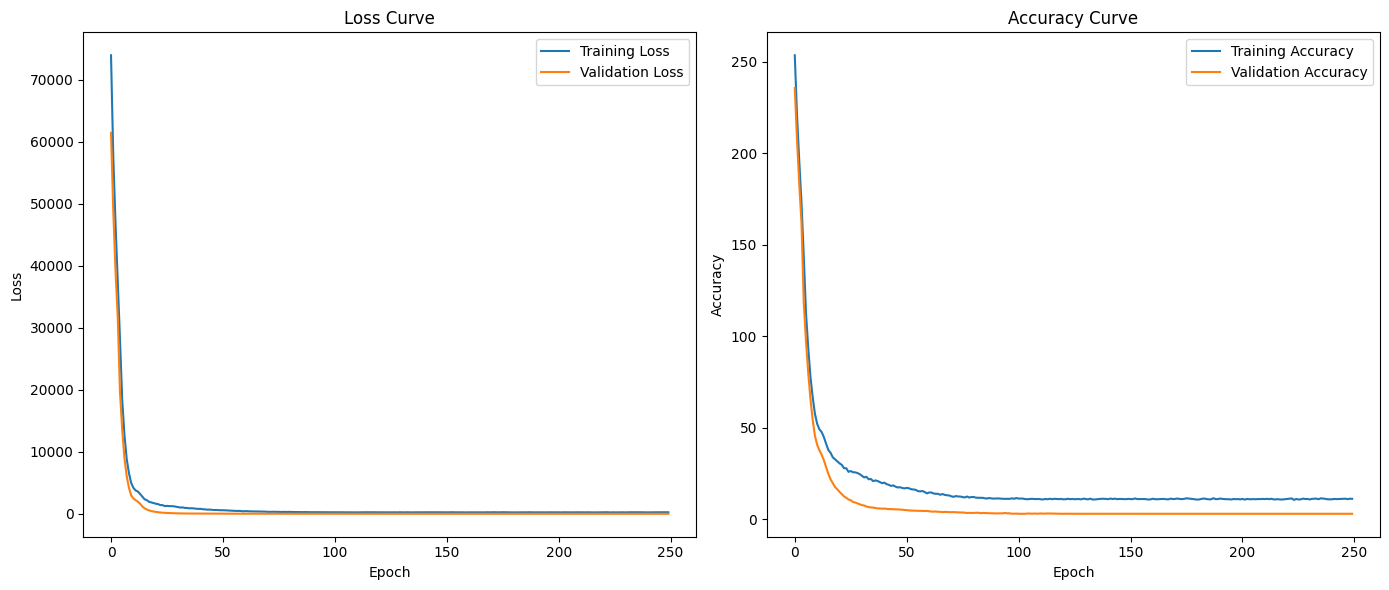

In [29]:
# Extract loss and accuracy values from history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['mae']
val_accuracy = history.history['val_mae']

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot loss
ax1.plot(loss, label='Training Loss')
ax1.plot(val_loss, label='Validation Loss')
ax1.set_title('Loss Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot accuracy
ax2.plot(accuracy, label='Training Accuracy')
ax2.plot(val_accuracy, label='Validation Accuracy')
ax2.set_title('Accuracy Curve')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Display plots
plt.tight_layout()
plt.show()